---
title: Informes Cambio de Componentes
subtitle: Revisión de completitud
author: Chief Reliability
date: 2023-01-23
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path

# # Define the path you want to add
# new_path = "/home/cecilvega/PycharmProjects/kverse"  # Path("C:\\Users\\andmn\\PycharmProjects\\kverse")
#
# # Convert Path object to string and append it to sys.path
# sys.path.append(str(new_path))

import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources.dplyr import *
from kdags.resources.tidyr import *
from io import BytesIO
import pdfplumber

# from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import *
import numpy as np

context = dg.build_asset_context()

from kdags.resources.ggplot import *

# from kdags.assets.operation.plm3.read_plm3 import read_raw_plm3

(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Weekly ICC Reports Status'}, xlabel='Week', ylabel='Number of Reports'>,
         week  total  missing  missing_percentage  available
 0   2024-W39      3        0                 0.0          3
 1   2024-W40      6        1                16.7          5
 2   2024-W41      4        0                 0.0          4
 3   2024-W42      4        0                 0.0          4
 4   2024-W43      6        0                 0.0          6
 5   2024-W44      5        0                 0.0          5
 6   2024-W45      6        0                 0.0          6
 7   2024-W46      6        0                 0.0          6
 8   2024-W47      6        3                50.0          3
 9   2024-W48      3        0                 0.0          3
 10  2024-W49      6        1                16.7          5
 11  2024-W50      1        0                 0.0          1
 12  2024-W51      3        0                 0.0          3
 13  2024-

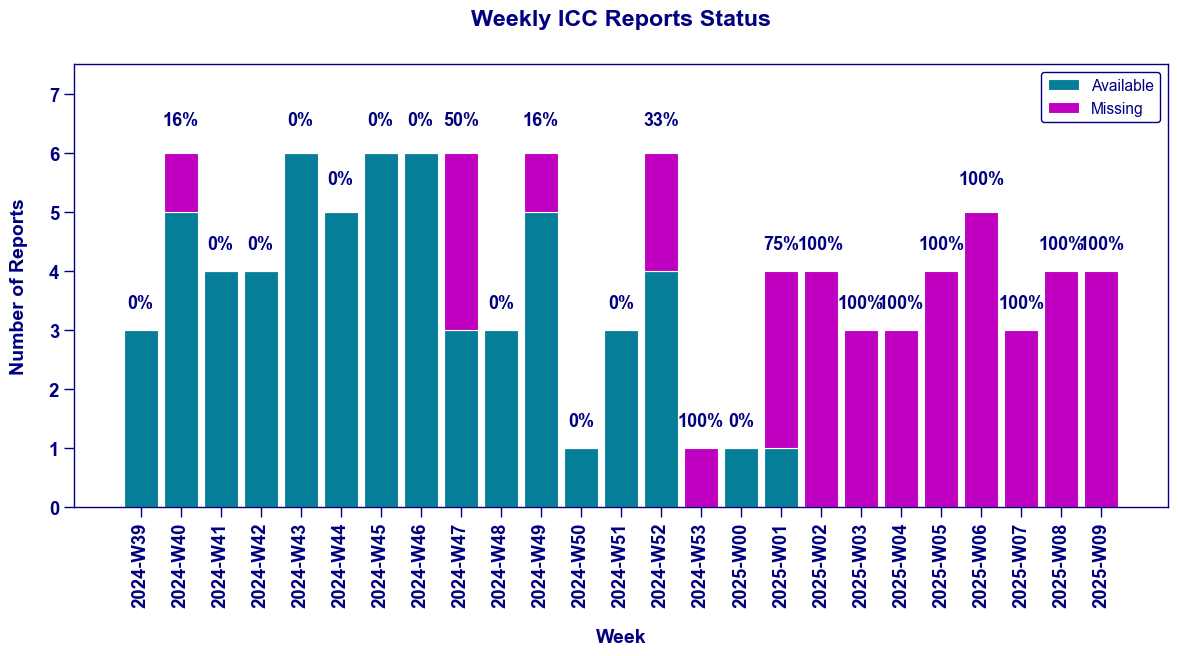

In [2]:
def create_icc_report(file_path=None):
    """
    Create the ICC report visualization using the GGPrism

    Parameters:
        file_path (str): Path to the Excel file with ICC data

    Returns:
        tuple: (fig, ax, weekly_summary) - Matplotlib figure, axis objects and data summary
    """
    # Import necessary libraries

    # Read the data if a file path is provided, otherwise use sample data
    if file_path:
        df = pd.read_excel(file_path)

        # Ensure date columns are proper datetime
        if "changeout_date" in df.columns:
            df["changeout_date"] = pd.to_datetime(df["changeout_date"])
        if "report_date" in df.columns:
            df["report_date"] = pd.to_datetime(df["report_date"])

        # Mark missing reports
        df["has_report"] = ~df["report_date"].isna()

        # Create week column based on changeout_date
        df["week"] = df["changeout_date"].dt.strftime("%Y-W%W")

        # Weekly analysis of missing reports
        weekly_summary = (
            df.groupby("week")
            .agg(
                total=("changeout_date", "count"),
                missing=("has_report", lambda x: (~x).sum()),
            )
            .reset_index()
        )

        weekly_summary["missing_percentage"] = (
            weekly_summary["missing"] / weekly_summary["total"] * 100
        ).round(1)
        weekly_summary["available"] = (
            weekly_summary["total"] - weekly_summary["missing"]
        )

        # Sort by week to ensure chronological order
        weekly_summary = weekly_summary.sort_values("week")

        # Filter to weeks with at least one record
        weekly_summary = weekly_summary[weekly_summary["total"] > 0]
    else:
        # Generate sample data for demonstration
        weeks = [f"2024-W{i:02d}" for i in range(1, 21)]

        np.random.seed(42)
        total = np.random.randint(3, 7, size=len(weeks))
        missing = np.random.randint(0, 3, size=len(weeks))
        missing = np.minimum(missing, total)  # Make sure missing <= total
        available = total - missing

        # Calculate missing percentage
        missing_percentage = (missing / total * 100).round().astype(int)

        weekly_summary = pd.DataFrame(
            {
                "week": weeks,
                "total": total,
                "missing": missing,
                "available": available,
                "missing_percentage": missing_percentage,
            }
        )

    # Create theme and figure
    theme = GGPrism()  # No palette parameter needed anymore
    fig, ax = theme.create_figure(figsize=(12, 7))

    # Plot stacked bars
    x = np.arange(len(weekly_summary))
    ax.bar(
        x,
        weekly_summary["available"],
        width=0.85,
        color=theme.COLORS[0],  # Use COLORS directly instead of PALETTES
        label="Available",
        edgecolor="white",
        linewidth=0.8,
    )
    ax.bar(
        x,
        weekly_summary["missing"],
        width=0.85,
        bottom=weekly_summary["available"],
        color=theme.COLORS[4],  # Use COLORS directly instead of PALETTES
        label="Missing",
        edgecolor="white",
        linewidth=0.8,
    )

    # Add percentage labels with improved positioning
    for i, row in enumerate(weekly_summary.itertuples()):
        # Adjust vertical position based on total value to prevent overlap
        vertical_offset = 0.3  # Base offset

        # Add more space for higher bars to prevent label overlap
        if row.total >= 5:
            vertical_offset = 0.4

        if row.missing > 0:
            ax.text(
                i,
                row.total + vertical_offset,  # Improved vertical positioning
                f"{int(row.missing_percentage)}%",
                ha="center",
                va="bottom",
                fontsize=13,  # Slightly smaller font for better fit
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )
        else:
            ax.text(
                i,
                row.total + vertical_offset,  # Improved vertical positioning
                "0%",
                ha="center",
                va="bottom",
                fontsize=13,  # Slightly smaller font for better fit
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )

    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(weekly_summary["week"], rotation=90)

    # Ensure y-axis has enough room for labels
    y_max = max(weekly_summary["total"]) + 1.5  # Add extra space for labels
    ax.set_ylim(0, y_max)

    # Apply styling and finalize plot
    theme.style_legend(ax, title="Report Status", loc="upper right")
    theme.finalize_plot(
        fig,
        ax,
        title="Weekly ICC Reports Status",
        xlabel="Week",
        ylabel="Number of Reports",
    )

    # Save the plot
    theme.save_plot(fig, "icc_report_plot.png")

    return fig, ax, weekly_summary


create_icc_report(file_path=r"C:\Users\vales\Downloads\icc.xlsx")

Weekly ICC Reports Summary:
        week  total  missing  missing_percentage
0   2024-W39      3        0                 0.0
1   2024-W40      6        1                16.7
2   2024-W41      4        0                 0.0
3   2024-W42      4        0                 0.0
4   2024-W43      6        0                 0.0
5   2024-W44      5        0                 0.0
6   2024-W45      6        0                 0.0
7   2024-W46      6        0                 0.0
8   2024-W47      6        3                50.0
9   2024-W48      3        0                 0.0
10  2024-W49      6        1                16.7
11  2024-W50      1        0                 0.0
12  2024-W51      3        0                 0.0
13  2024-W52      6        2                33.3
14  2024-W53      1        1               100.0
15  2025-W00      1        0                 0.0
16  2025-W01      4        3                75.0
17  2025-W02      4        4               100.0
18  2025-W03      3        3             

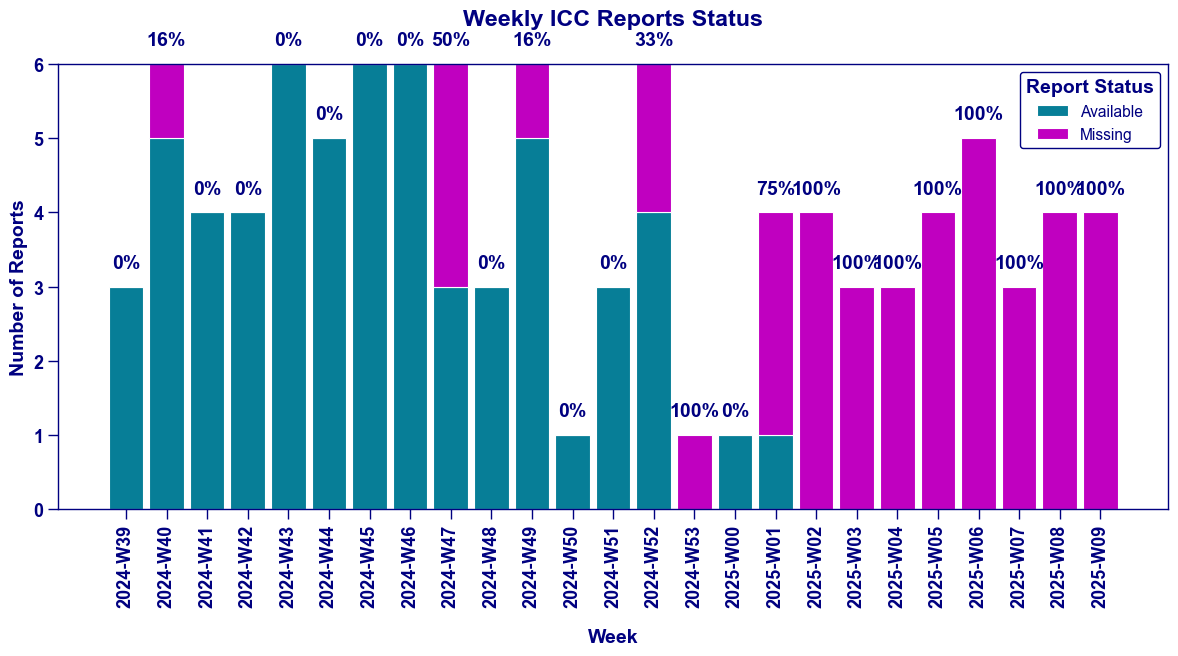

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

# Set styles to match ggprism winter_bright exactly
plt.rcParams["font.family"] = "sans"
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["font.weight"] = "bold"  # Make all text bold by default

# Define the exact ggprism colors
AXIS_COLOR = "#000080"  # navy blue - exact ggprism axisColor
AVAILABLE_COLOR = "#077E97"  # winter_bright color 1
MISSING_COLOR = "#C000C0"  # winter_bright color 5 (purple)

# Increase default font sizes to match ggprism base_size=14
plt.rcParams["font.size"] = 14

# Read the actual ICC data
df = pd.read_excel(r"C:\Users\vales\Downloads\icc.xlsx")

# Ensure date columns are proper datetime
if "changeout_date" in df.columns:
    df["changeout_date"] = pd.to_datetime(df["changeout_date"])
if "report_date" in df.columns:
    df["report_date"] = pd.to_datetime(df["report_date"])

# Mark missing reports
df["has_report"] = ~df["report_date"].isna()

# Create week column based on changeout_date
df["week"] = df["changeout_date"].dt.strftime("%Y-W%W")

# Weekly analysis of missing reports
weekly_summary = (
    df.groupby("week")
    .agg(
        total=("changeout_date", "count"), missing=("has_report", lambda x: (~x).sum())
    )
    .reset_index()
)

weekly_summary["missing_percentage"] = (
    weekly_summary["missing"] / weekly_summary["total"] * 100
).round(1)
weekly_summary["available"] = weekly_summary["total"] - weekly_summary["missing"]

# Sort by week to ensure chronological order
weekly_summary = weekly_summary.sort_values("week")

# Filter to weeks with at least one record
weekly_summary = weekly_summary[weekly_summary["total"] > 0]

# Create the plot with ggprism proportions
fig, ax = plt.subplots(figsize=(12, 7))  # Slightly taller figure for better proportions

# Plot stacked bars with no gaps between them (width=0.85)
x = np.arange(len(weekly_summary))
ax.bar(
    x,
    weekly_summary["available"],
    width=0.85,
    color=AVAILABLE_COLOR,
    label="Available",
    edgecolor="white",
    linewidth=0.8,
)
ax.bar(
    x,
    weekly_summary["missing"],
    width=0.85,
    bottom=weekly_summary["available"],
    color=MISSING_COLOR,
    label="Missing",
    edgecolor="white",
    linewidth=0.8,
)

# Add percentage labels directly above bars - with integer percentages
for i, row in enumerate(weekly_summary.itertuples()):
    # Only show percentage if there are any missing reports
    if row.missing > 0:
        ax.text(
            i,
            row.total + 0.2,  # Adjusted positioning
            f"{int(row.missing_percentage)}%",  # Integer percentage
            ha="center",
            va="bottom",
            fontsize=14,  # Match ggprism default base size
            fontweight="bold",
            color=AXIS_COLOR,  # Use the exact ggprism axis color
        )
    else:
        ax.text(
            i,
            row.total + 0.2,
            "0%",  # Integer percentage (no decimal)
            ha="center",
            va="bottom",
            fontsize=14,  # Match ggprism default base size
            fontweight="bold",
            color=AXIS_COLOR,  # Use the exact ggprism axis color
        )

# Style all text with the exact ggprism colors
# Customize x-axis
ax.set_xticks(x)
ax.set_xticklabels(
    weekly_summary["week"],
    rotation=90,
    ha="center",
    fontsize=13,  # Slightly smaller than base size
    fontweight="bold",
    color=AXIS_COLOR,
)
ax.set_xlabel("Week", fontsize=14, fontweight="bold", color=AXIS_COLOR, labelpad=15)

# Set y-axis to have integer ticks only
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Number of Reports", fontsize=14, fontweight="bold", color=AXIS_COLOR)
ax.tick_params(
    axis="y", colors=AXIS_COLOR, labelsize=13
)  # Slightly smaller than base size

# Set title with proper styling to match ggprism
ax.set_title(
    "Weekly ICC Reports Status",
    fontsize=16.8,  # 1.2 times the base size (14*1.2) following ggprism
    fontweight="bold",
    color=AXIS_COLOR,
    pad=28,  # Match ggprism margin
)

# Remove all grid lines as requested
ax.grid(False)  # No grid lines at all

# Set clean white background matching ggprism
fig.patch.set_facecolor("white")  # pageBackgroundColor
ax.set_facecolor("white")  # plottingAreaColor

# Make all spines the exact ggprism axis color and width
for spine in ax.spines.values():
    spine.set_color(AXIS_COLOR)
    spine.set_linewidth(1.0)  # ggprism default is base_size/14 = 1.0 for base_size=14

# Make tick marks match ggprism
ax.tick_params(
    width=1.0, length=7, colors=AXIS_COLOR
)  # ggprism default length is base_size/2

# Add legend styled according to ggprism standards
legend = ax.legend(
    title="Report Status",
    frameon=True,
    loc="upper right",
    title_fontsize=14,  # Base size
    fontsize=11.2,  # 0.8 * base_size following ggprism
    framealpha=1.0,
)
legend.get_frame().set_linewidth(1.0)  # ggprism default
legend.get_frame().set_edgecolor(AXIS_COLOR)
legend.get_title().set_fontweight("bold")
legend.get_title().set_color(AXIS_COLOR)

# Make all legend text the ggprism axis color
for text in legend.get_texts():
    text.set_color(AXIS_COLOR)
    # Set legend text to plain (not bold) - ggprism specification
    text.set_fontweight("normal")

# Adjust layout following ggprism margins
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Match ggprism margins

# Print summary
print("Weekly ICC Reports Summary:")
print(weekly_summary[["week", "total", "missing", "missing_percentage"]])

# Save and show the plot with higher DPI for clarity
plt.savefig(
    "weekly_icc_reports.png",
    dpi=300,
    bbox_inches="tight",
    facecolor=fig.get_facecolor(),
)
plt.show()